<a href="https://colab.research.google.com/github/Ed-Marcavage/PyTorch/blob/Exercises/classification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
from sklearn.datasets import make_moons

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_moons(n_samples, noise=0.03, random_state=42)

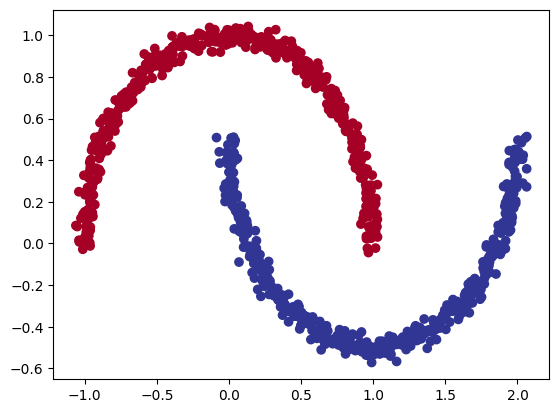

In [115]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [116]:
import torch
from torch import nn

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]
X.shape

torch.Size([1000, 2])

In [117]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [118]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

In [120]:
class ExerciseModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=X.shape[1], out_features=10) # takes in 2 features (X), UPSCALES to 5 features
    self.layer_2 = nn.Linear(in_features=10, out_features=10) # takes in 5 features, produces 1 feature (y)
    self.layer_3 = nn.Linear(in_features=10, out_features=len(y.shape)) # takes in 5 features, produces 1 feature (y)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# 4. Create an instance of the model and send it to target device
model_0 = ExerciseModel().to(device)
model_0


ExerciseModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [121]:
device, next(model_0.parameters()).device

('cpu', device(type='cpu'))

In [122]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [123]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_0(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.0016, 0.0098, 0.0175, 0.0183, 0.0287, 0.0182, 0.0310, 0.0180, 0.0242,
        0.0082], grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5004, 0.5025, 0.5044, 0.5046, 0.5072, 0.5046, 0.5077, 0.5045, 0.5060,
        0.5020], grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<RoundBackward0>)


In [124]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [125]:
# Let's calculate the accuracy
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [126]:
torch.manual_seed(42)
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Forward Pass
  # y_prediction = model_0(X_train);
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

  # Calc the Loss
  loss_train = loss_fn(y_logits, y_train);

  # Calc the accuracy
  # acc = accuracy_fn(y_true=y_train,
  #                     y_pred=y_pred)
  acc = acc_fn(y_pred, y_train.int())

  # Zero Grad
  optimizer.zero_grad();

  # Perform Backpropagation on the loss
  loss_train.backward();

  # 3. Optimizer zero grad
  optimizer.step();

  if epoch % 100 == 0:

    model_0.eval()
    with torch.inference_mode():
      # Forward Pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # turn logits -> pred probs -> pred labls

    # Calc the Loss
      test_loss = loss_fn(test_logits,
                            y_test)
      # test_acc = accuracy_fn(y_true=y_test,
      #                          y_pred=test_pred)
      test_acc = acc_fn(test_pred, y_test.int())
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Accuracy: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")










# Set the optimizer (adjust model parmams/weights - gradient descent)




Epoch: 0 | Loss: 0.69537, Accuracy: 0.38% | Test loss: 0.69457, Test acc: 0.50%
Epoch: 100 | Loss: 0.38636, Accuracy: 0.82% | Test loss: 0.40196, Test acc: 0.77%
Epoch: 200 | Loss: 0.23664, Accuracy: 0.89% | Test loss: 0.23758, Test acc: 0.90%
Epoch: 300 | Loss: 0.19082, Accuracy: 0.91% | Test loss: 0.18528, Test acc: 0.93%
Epoch: 400 | Loss: 0.15147, Accuracy: 0.94% | Test loss: 0.14452, Test acc: 0.94%
Epoch: 500 | Loss: 0.10692, Accuracy: 0.96% | Test loss: 0.09974, Test acc: 0.98%
Epoch: 600 | Loss: 0.06902, Accuracy: 0.99% | Test loss: 0.06298, Test acc: 0.99%
Epoch: 700 | Loss: 0.04417, Accuracy: 1.00% | Test loss: 0.03936, Test acc: 1.00%
Epoch: 800 | Loss: 0.03007, Accuracy: 1.00% | Test loss: 0.02625, Test acc: 1.00%
Epoch: 900 | Loss: 0.02188, Accuracy: 1.00% | Test loss: 0.01887, Test acc: 1.00%


In [127]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


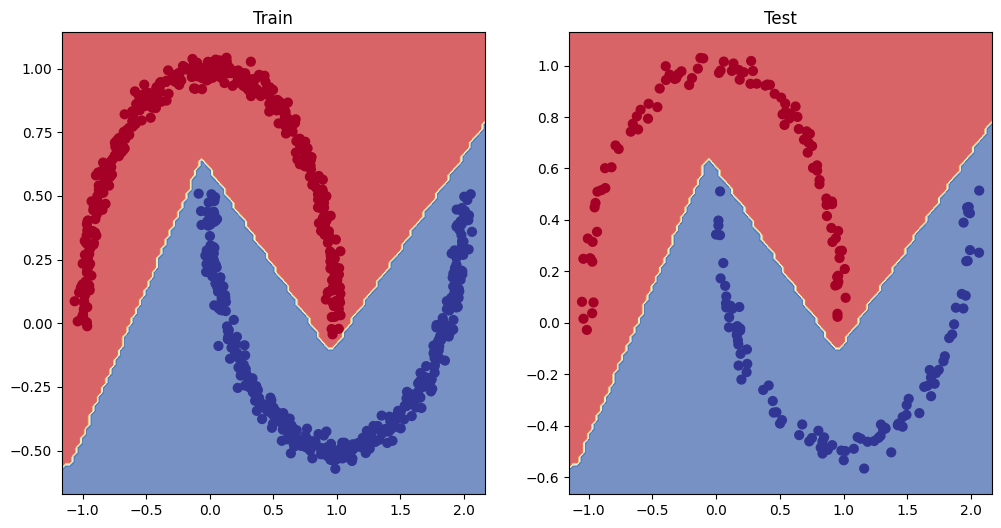

In [128]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

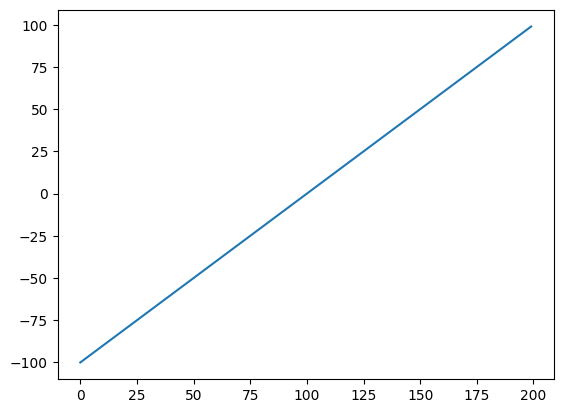

In [143]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

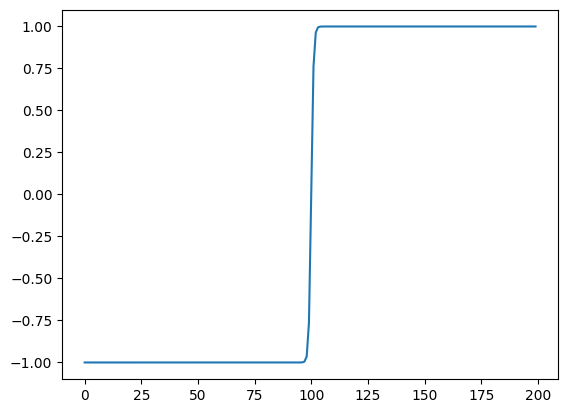

In [144]:
plt.plot(torch.tanh(tensor_A))

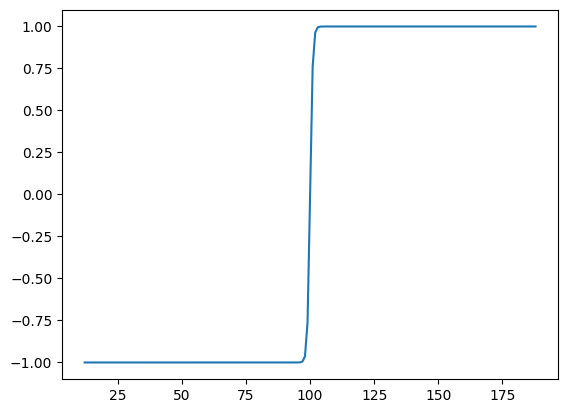

In [147]:
def Tanh(x: int):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(Tanh(tensor_A))

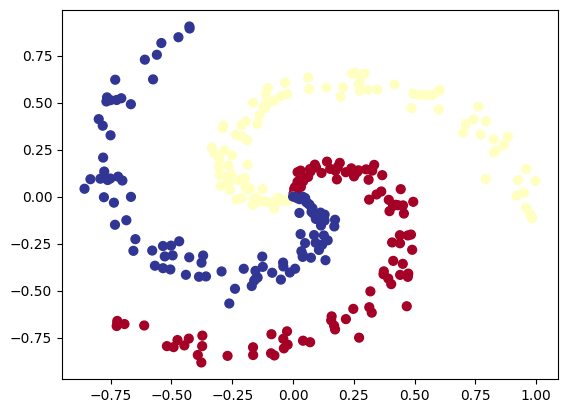

(240, 60, 240, 60)

In [157]:
# Code for creating a spiral dataset from CS231n
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

In [162]:
from torch import nn

class SpiralModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=X.shape[1], out_features=50)
    self.layer_2 = nn.Linear(in_features=50, out_features=50)
    self.layer_3 = nn.Linear(in_features=50, out_features=50)
    self.layer_4 = nn.Linear(in_features=50, out_features=3)
    self.relu = nn.ReLU() # <- add in ReLU activation function
    # Can also put sigmoid in the model
    # This would mean you don't need to use it on the predictions
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = SpiralModelV2().to(device)
print(model_3)

SpiralModelV2(
  (layer_1): Linear(in_features=2, out_features=50, bias=True)
  (layer_2): Linear(in_features=50, out_features=50, bias=True)
  (layer_3): Linear(in_features=50, out_features=50, bias=True)
  (layer_4): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
)


In [163]:
len(y.shape)

1

In [164]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_3(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_3(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_3(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[0.0367, 0.0849, 0.1364],
        [0.0254, 0.0871, 0.1291],
        [0.0516, 0.0957, 0.1412],
        [0.0411, 0.1008, 0.1360],
        [0.0504, 0.1068, 0.1566],
        [0.0540, 0.1030, 0.1451],
        [0.0550, 0.1018, 0.1442],
        [0.0342, 0.0631, 0.1394],
        [0.0294, 0.0918, 0.1339],
        [0.0413, 0.1009, 0.1362]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3170, 0.3327, 0.3503],
        [0.3152, 0.3352, 0.3496],
        [0.3186, 0.3330, 0.3485],
        [0.3163, 0.3358, 0.3478],
        [0.3155, 0.3337, 0.3508],
        [0.3179, 0.3339, 0.3482],
        [0.3183, 0.3336, 0.3481],
        [0.3185, 0.3278, 0.3538],
        [0.3150, 0.3353, 0.3497],
        [0.3164, 0.3358, 0.3479]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [165]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)

In [168]:
# Fit the model
torch.manual_seed(42)
epochs = 5000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  # Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calc Loss & Acc
  train_loss = loss_fn(y_pred, y_train)
  acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

  # Zero Optimizer
  optimizer.zero_grad()

  #back propagation
  train_loss.backward()

  # Optimizer step
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
      if epoch % 500 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")




ValueError: ignored